
---

## 因子实战 第拾贰（XII）集 
# 因子回测 Backtesting 系列：一个因子的<span style="color: red;">难产</span>之路
#### 哈老师，你的新视频做好了吗？

### 🎬 大导演哈罗德
#### 欢迎来到哈罗德的*量化频道*
- 香港中文大学（深圳）金融工程本科
- 下一步学业：即将前往美国攻读金融工程硕士（已获得录取）
- 🌐 [关注我的Bilibili，看所有人都能听得懂的量化学习内容](https://space.bilibili.com/629573485)
- 🌐 [点击这里关注我的YouTube](https://www.youtube.com/@BD_Harold)
- 
🌟🌟🌟 我有一个梦想，就是让量化变成不再是束之高阁的灵丹妙药，而是让散户投资者认识市场风险最好的工具 @哈罗德的量化频道 🌟🌟🌟

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.api import OLS

import warnings
warnings.filterwarnings("ignore")

from simple_factor_process import FactorProcessing_CorrelationBetweenTwoFactors as FactorIC # 因子IC
from simple_factor_process import FactorTool_GetStockSplit as FactorGroup # 分组
from simple_factor_process import FactorPurify # 中性化

# stock data
sw_ind = pd.read_pickle('数据/IndexComponent_SWN_I.txt')
stock_close = pd.read_pickle('数据/StockQuote_ClosePrice_BackwardAdj.txt')
stock_open = pd.read_pickle('数据/StockQuote_OpenPrice_BackwardAdj.txt')
monthly_trading_day = pd.read_pickle('数据/monthly_trading_day.pkl')
monthly_trading_day['start_date'] = pd.to_datetime(monthly_trading_day['start_date'], format='%Y%m%d')
monthly_trading_day['end_date'] = pd.to_datetime(monthly_trading_day['end_date'], format='%Y%m%d')
start_date = pd.to_datetime('20120101', format='%Y%m%d')
end_date = pd.to_datetime('20231231', format='%Y%m%d')
filtered_trading_days = monthly_trading_day.loc[(monthly_trading_day['end_date'] >= start_date) & (monthly_trading_day['end_date'] <= end_date)]
stock_close.index = pd.to_datetime(stock_close.index)
stock_open.index = pd.to_datetime(stock_open.index)
stock_ret_monthly = stock_close.reindex(index = filtered_trading_days.end_date).pct_change() 
stock_ret_monthly_nextopen = stock_open.shift(-1).reindex(filtered_trading_days.end_date).pct_change()

# function
def simple_factor_test(factor, use_data = 'this_close'):
    if use_data=='this_close':
        this_ret_data = stock_ret_monthly.shift(-1)
    else: 
        this_ret_data = stock_ret_monthly_nextopen.shift(-1)
    ic,rankic = FactorIC(factor,this_ret_data) # 计算因子的ic,rankic序列
    factor_group = FactorGroup(factor)
    condata = pd.concat([factor_group.unstack(),this_ret_data.unstack()],axis=1).dropna().reset_index()
    condata.columns =['stockcode','date','group_id','ret']
    group_ret = condata.groupby(['date','group_id'])['ret'].mean().unstack()
    return ic,rankic,group_ret,factor_group

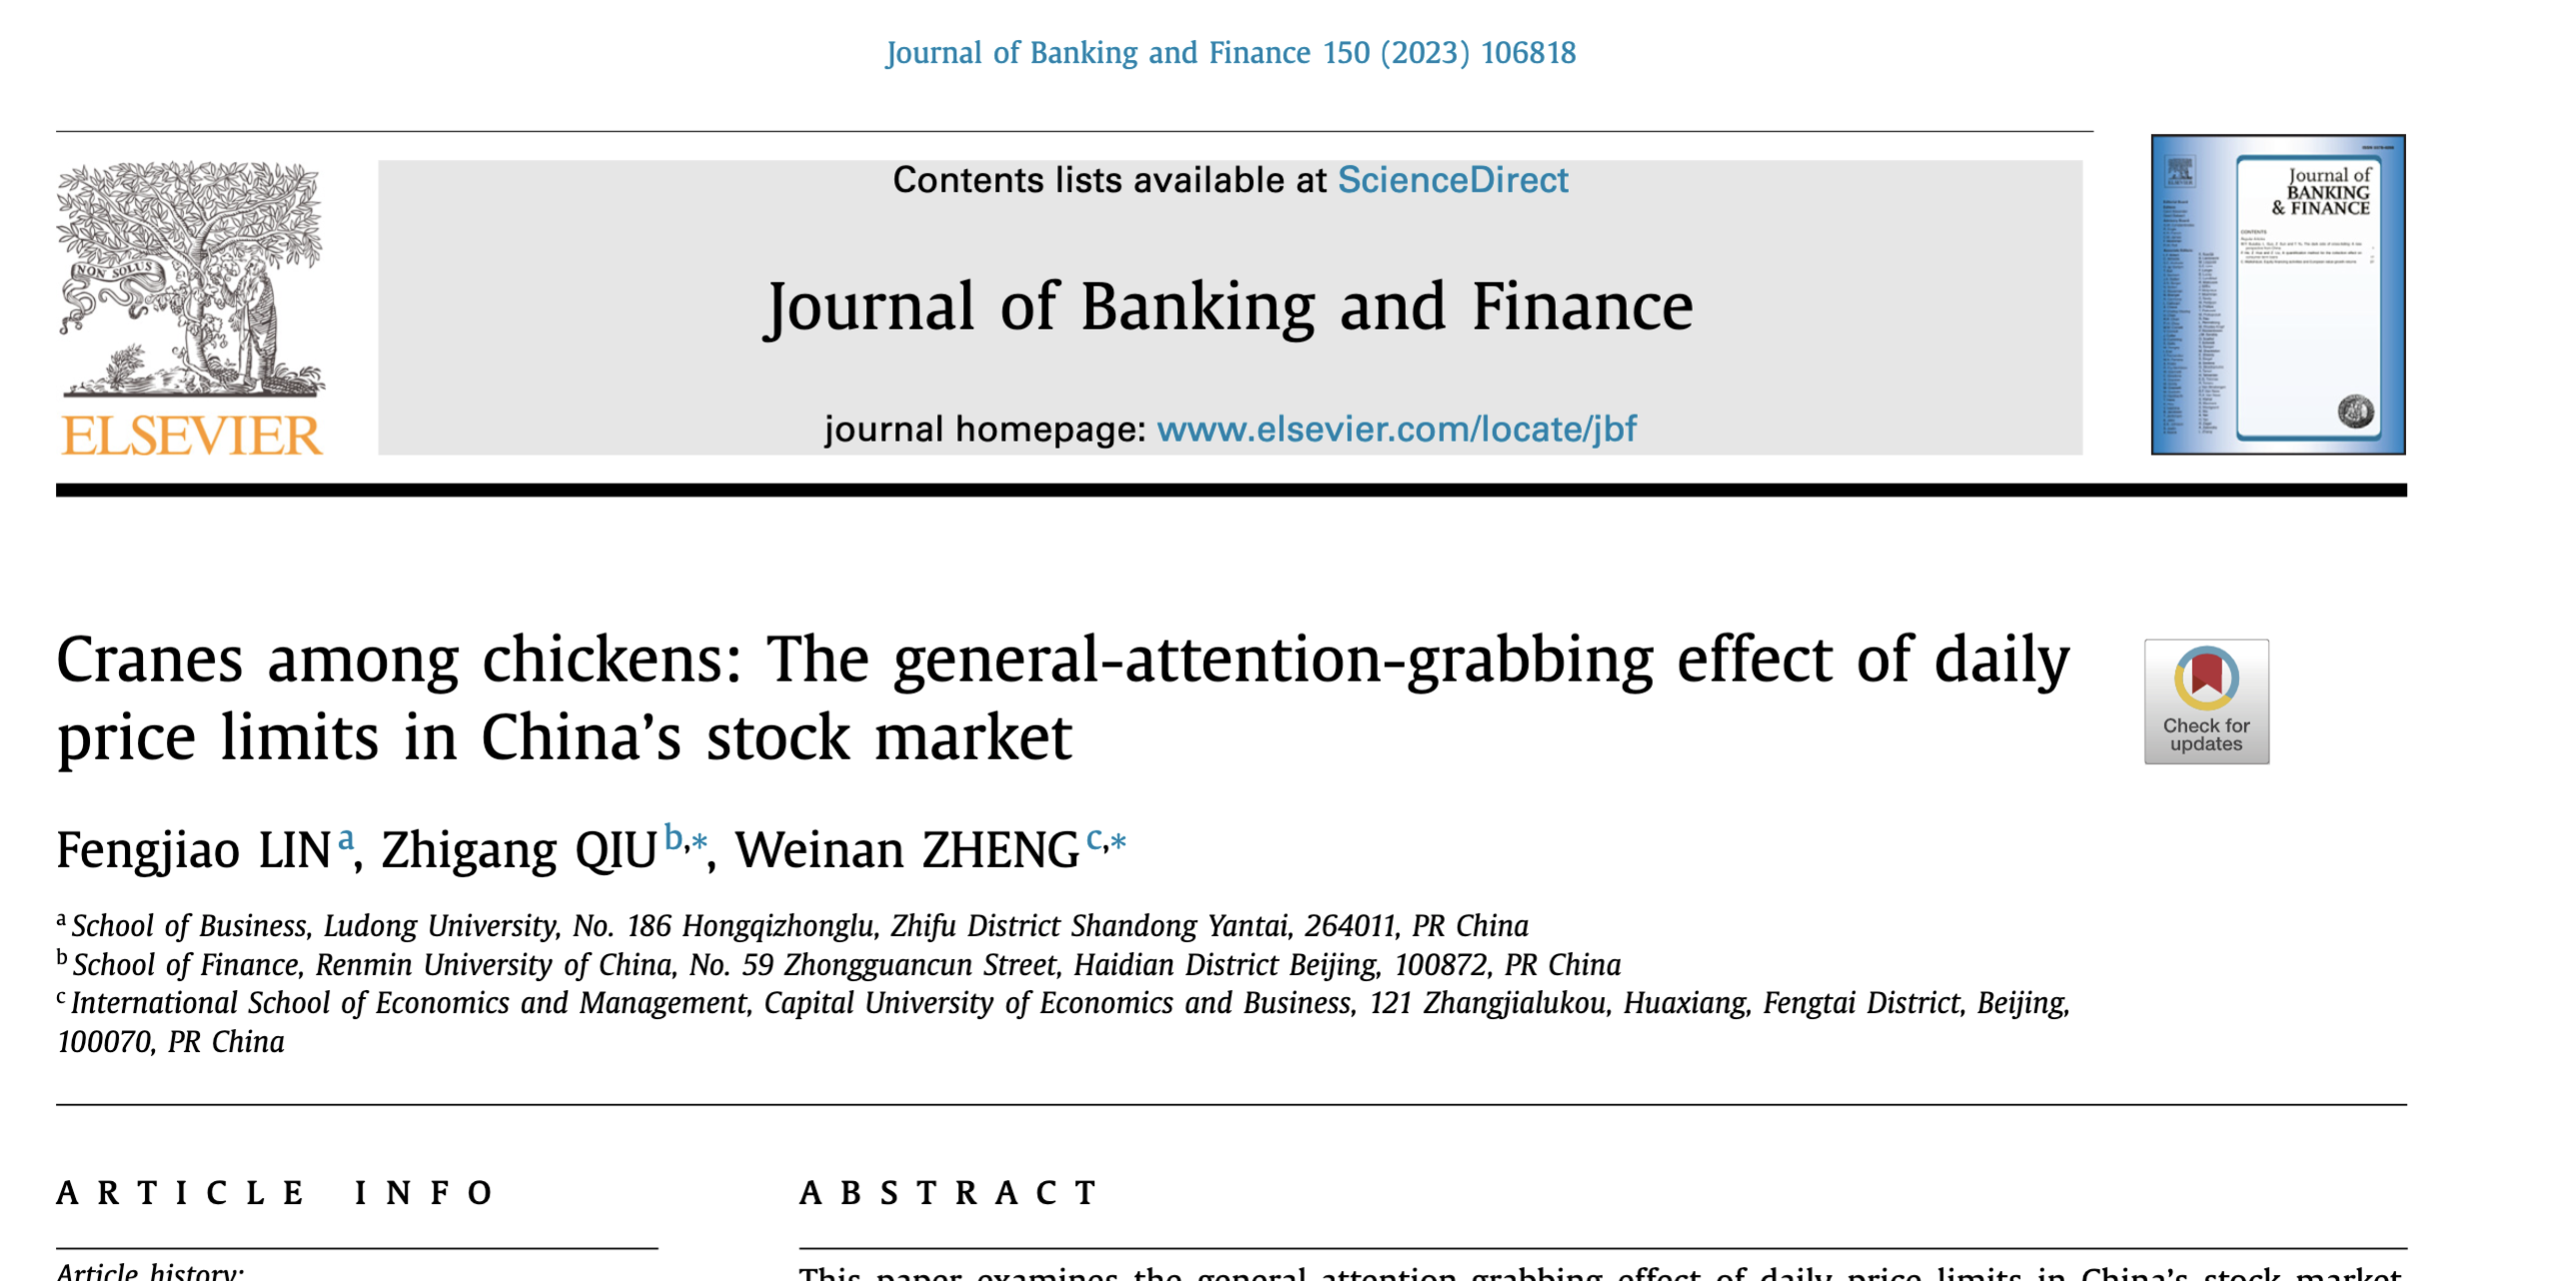

This paper examines the general-attention-grabbing effect of daily price limits in China’s stock market.
We show that stocks with large exposure to daily price limits attract more investor attention and have
lower future returns. The exposure is measured empirically through the absolute beta with respect to the
daily proportion of stocks that hit price limits. The general-attention-grabbing effect is not solely caused
by stocks that recently hit price limits, is not subsumed by market volatility exposure, and does not
reﬂect other stock market characteristics. Moreover, the effect is stronger among stocks that are heavily
invested in by retail investors.

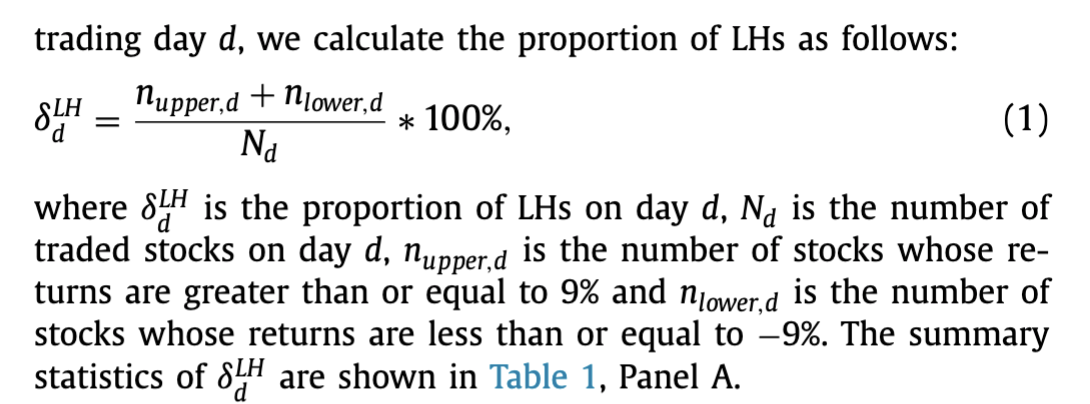

说白了。
一个指标ZT：涨跌停股票占比。
因子值：股票对ZT的敏感程度（用回归系数来衡量）

In [2]:
# 构建方法：涨跌停的比列
ZT = (stock_close - stock_open) / stock_open 
number_of_stocks = ZT.T.count()
ZT = abs(ZT) >= 0.09 
number_of_stocks_toomuch = ZT.T.sum()
factor = number_of_stocks_toomuch / number_of_stocks
factor.replace(np.nan, 0, inplace = True) 



# select 2012 - 2023
factor = factor.loc['20120101':'20231231']
factor.index = pd.to_datetime(factor.index)
famafrench = pd.read_excel("STK_MKT_THRFACDAY.xlsx")
famafrench = famafrench[famafrench['MarkettypeID'] == "P9706"]
famafrench = famafrench.reset_index(drop= True)
famafrench = famafrench.set_index("TradingDate").loc["2012-01-01" : '2023-12-31'][['RiskPremium2', "SMB2", "HML2"]]
fourfactors = pd.merge(pd.DataFrame(factor).reset_index(), famafrench.reset_index() , left_index=True, right_index=True, how='left')
fourfactors.columns = ["Tradingdays","APL", "TradingDate", "RiskPremium2", "SMB2", "HML2"]
fourfactors_reordered = fourfactors[[ 'TradingDate','APL', 'RiskPremium2', 'SMB2', 'HML2']]
fourfactors_reordered ['TradingDate'] = pd.to_datetime(fourfactors_reordered ['TradingDate'])
fourfactors_reordered = fourfactors_reordered.set_index('TradingDate')
fourfactors_reordered

,APL,RiskPremium2,SMB2,HML2
TradingDate,,,,
2012-01-04,0.011760,-0.016205,-0.004502,0.00939
2012-01-05,0.027439,-0.013403,-0.027523,0.01463
2012-01-06,0.005220,0.00707,-0.002101,0.000992
2012-01-09,0.028273,0.030277,0.008748,-0.010063
2012-01-10,0.026945,0.028804,0.006326,-0.014061
...,...,...,...,...
2023-12-25,0.013508,0.00202,-0.00887,-0.001847
2023-12-26,0.010692,-0.005552,-0.005357,0.004727
2023-12-27,0.008815,0.0064,0.002296,0.002342


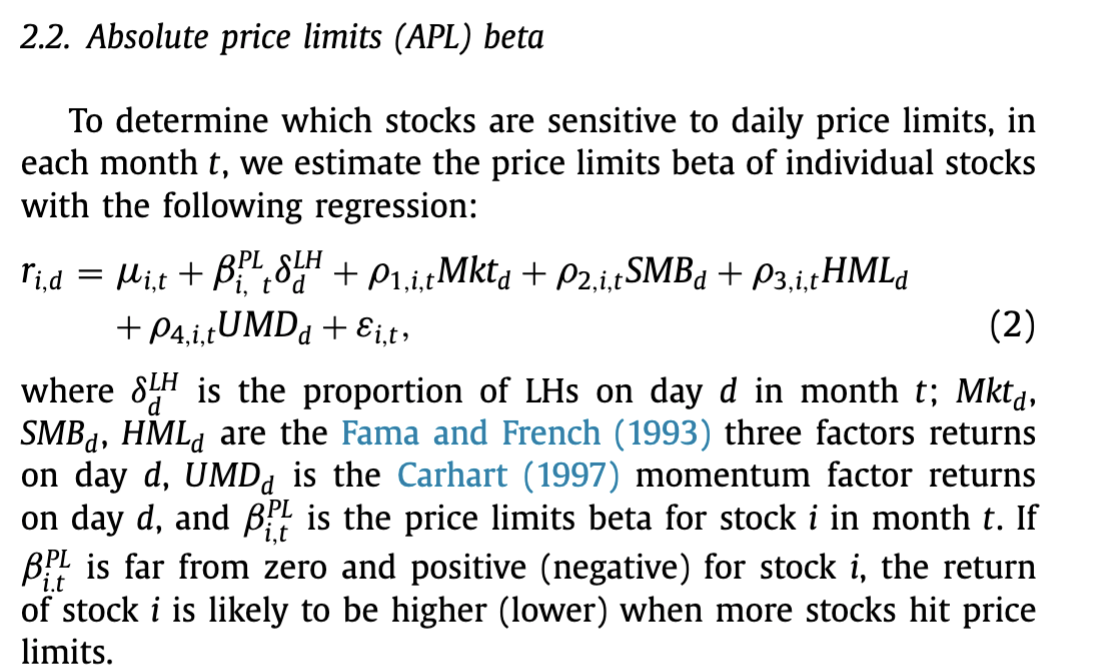

In [3]:
filtered_trading_days

,start_date,end_date
24,2012-01-04,2012-01-31
25,2012-02-01,2012-02-29
26,2012-03-01,2012-03-30
27,2012-04-05,2012-04-27
28,2012-05-02,2012-05-31
...,...,...
162,2023-07-03,2023-07-31
163,2023-08-01,2023-08-31
164,2023-09-01,2023-09-28
165,2023-10-09,2023-10-31


In [3]:
all_results = {}
# 计算全部股票收益率
daily_returns = stock_close.pct_change()
daily_returns = daily_returns.loc['20120101':'20231231', :]
daily_returns.index = pd.to_datetime(daily_returns.index)

all_results = {}

for stock in daily_returns.columns:
    
    Y = daily_returns[stock]
    X = fourfactors_reordered
    X['RiskPremium2'] = pd.to_numeric(X['RiskPremium2'], errors='coerce')
    X['SMB2'] = pd.to_numeric(X['SMB2'], errors='coerce')
    X['HML2'] = pd.to_numeric(X['HML2'], errors='coerce')

    # match the index of X and Y
    Y = Y.loc[X.index]
    # print(Y)
    # print(X)
    
    stock_results = {}

    for index, row in filtered_trading_days.iterrows():
        
        start_date = pd.to_datetime(row['start_date'], format='%Y%m%d')
        end_date = pd.to_datetime(row['end_date'], format='%Y%m%d')
        X_subset = X.loc[(X.index >= start_date) & (X.index <= end_date)]
        Y_subset = Y.loc[(Y.index >= start_date) & (Y.index <= end_date)]

        if len(X_subset) == len(Y_subset) and len(X_subset) > 0:

            # handle missing values
            X_subset = X_subset.dropna()
            Y_subset = Y_subset.loc[X_subset.index]

            X_subset = X_subset.reset_index(drop=True)
            Y_subset = Y_subset.reset_index(drop=True)

            # Add a constant for the regression intercept
            X_with_const = sm.add_constant(X_subset, has_constant='add')
            

            # Run the regression
            model = sm.OLS(Y_subset, X_with_const)
            regression_results = model.fit()

            # Store the regression results for this month
            stock_results[end_date] = regression_results.params

        else:
            print('No data for stock {} for the period from {} to {}'.format(stock, start_date, end_date))
            stock_results[end_date] = np.nan

    # Store the results for the current stock
        all_results[stock] = stock_results
    # break

# Convert all_results to a DataFrame for a clean and organized output
all_params = {(outerKey, innerKey): values for outerKey, innerDict in all_results.items() for innerKey, values in innerDict.items()}
param_df = pd.DataFrame(all_params).T
param_df.index.names = ['Stock', 'End_Date']

# Display the organized results
print(param_df)


                         const       APL  RiskPremium2      SMB2      HML2
Stock     End_Date                                                        
000001.SZ 2012-01-31  0.008667 -0.401748      0.660584 -0.509253  0.059457
          2012-02-29  0.001788  0.006929      0.981190 -0.654536  1.027356
          2012-03-30 -0.002668  0.229163      1.020852  0.123346  1.078212
          2012-04-27  0.003438 -0.274680      1.247097 -0.037041  1.435883
          2012-05-31 -0.001788 -0.121611      0.910296 -0.287862 -0.264949
...                        ...       ...           ...       ...       ...
T00018.SH 2023-07-31  0.000000  0.000000      0.000000  0.000000  0.000000
          2023-08-31  0.000000  0.000000      0.000000  0.000000  0.000000
          2023-09-28  0.000000  0.000000      0.000000  0.000000  0.000000
          2023-10-31  0.000000  0.000000      0.000000  0.000000  0.000000
          2023-11-30  0.000000  0.000000      0.000000  0.000000  0.000000

[797082 rows x 5 columns

In [4]:
pivoted_df = param_df["APL"].unstack().T
pivoted_df.index = pd.to_datetime(pivoted_df.index)
pivoted_df_monthly = pivoted_df.reindex(index = filtered_trading_days.end_date) # 按月抽样得到因子值
pivoted_df_monthly

Stock,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,873570.BJ,873576.BJ,873593.BJ,873665.BJ,873679.BJ,873693.BJ,873703.BJ,873726.BJ,873833.BJ,T00018.SH
end_date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,-0.401748,-0.324833,NaN,0.454989,0.000000,-0.656124,0.516544,-0.656759,0.433216,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2012-02-29,0.006929,1.719005,NaN,-0.988313,0.000000,2.165272,0.150120,-2.583994,-5.044750,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2012-03-30,0.229163,0.145142,NaN,-1.296899,0.000000,-1.969260,0.608640,0.428354,0.400727,-1.393215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2012-04-27,-0.274680,0.640345,NaN,-0.614145,0.794401,1.429357,-0.439736,-2.466682,-2.972336,-2.962944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2012-05-31,-0.121611,-1.160346,NaN,-0.923041,-0.744697,-3.501537,1.722447,-0.592812,-2.771338,1.884304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,0.250306,-0.973746,NaN,4.467019,1.173802,-1.813160,-1.846236,0.992861,-0.705706,3.769452,...,NaN,3.976434,-1.758814,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2023-08-31,0.272341,0.777558,NaN,-0.714721,0.342610,1.578857,0.225707,0.111840,0.005544,0.284633,...,NaN,1.355420,-0.354216,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2023-09-28,0.426425,2.783153,NaN,-1.505853,-2.773419,2.229495,-3.455124,-2.801404,-0.726524,-6.906632,...,NaN,-4.887391,2.744715,NaN,NaN,NaN,NaN,NaN,NaN,0.0


把我的因子值按照大小分成5组，然后看看这5组的平均收益率。

In [5]:
ic,rankic,group_ret,factor_group  = simple_factor_test(pivoted_df_monthly)

In [6]:
rank_ic_mean = ic.mean()
rank_ic_std = ic.std()
rank_icir = rank_ic_mean / rank_ic_std if rank_ic_std != 0 else float('nan')
ic_win_rate = (ic > 0).mean()

print(f"Rank IC Mean: {rank_ic_mean:.4f}")
print(f"Rank ICIR: {rank_icir:.4f}")
print(f"IC Win Rate: {ic_win_rate:.2%}")


Rank IC Mean: -0.0086
Rank ICIR: -0.1337
IC Win Rate: 45.45%


In [7]:
group_ret


group_id,0.0,1.0,2.0,3.0,4.0
date,,,,,
2012-01-31,0.150492,0.129042,0.117919,0.125514,0.126967
2012-02-29,-0.075643,-0.061035,-0.076724,-0.071360,-0.085049
2012-03-30,0.059686,0.070442,0.069077,0.069239,0.063299
2012-04-27,0.044728,0.028867,0.019262,0.015932,0.014104
2012-05-31,-0.043312,-0.057521,-0.054113,-0.053337,-0.068220
...,...,...,...,...,...
2023-06-30,-0.021354,0.026048,0.033669,0.024802,-0.010739
2023-07-31,-0.041256,-0.041823,-0.037477,-0.041316,-0.032562
2023-08-31,-0.009578,0.003439,0.004493,0.006837,-0.010086


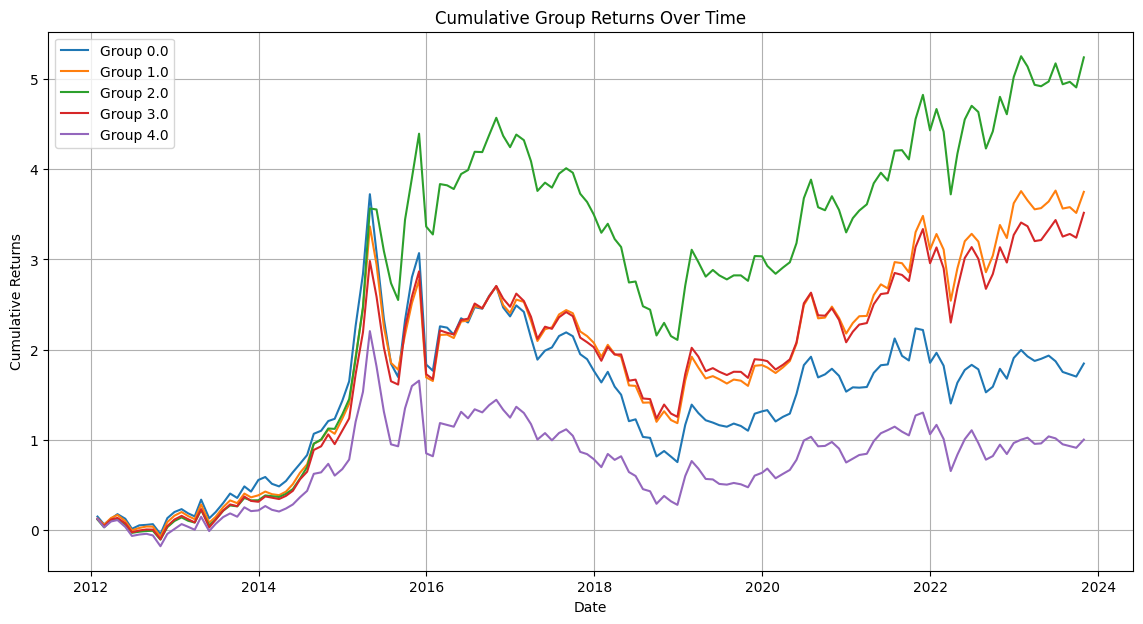

In [9]:
cumulative_returns = (1 + group_ret).cumprod() - 1

# 绘制累积收益率
plt.figure(figsize=(14, 7))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=f'Group {column}')

plt.title('Cumulative Group Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
